In [19]:
# some python imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import astropy as ap
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import pandas as pd

from lenstronomy.Util import util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit



In [20]:
filepath = '/Users/gilliancartwright/Desktop/DES data/' # my personal file path
filename = filepath + 'Rob_candidates.fits'

hdu_list = fits.open(filepath+'Rob_candidates.fits')
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()
data.head()




,COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,...,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,FWHM_WMEAN_Z,SKYBRITE_WMEAN_G,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z,NAME,NAME_FOLDER
0,1400263522,DES0336-2915,2354916223,147182263,0.938449,53.898900,-28.912203,3.962615,4.879757,4.983489,...,1.09654,0.943639,0.817035,0.899360,390.652008,947.728027,3299.189941,7099.970215,DES-691022126,DES0336-2915
1,1325853948,DES0242-0041,1163420627,72713789,0.006323,40.969310,-0.619002,10.245866,10.665524,11.179090,...,1.09442,0.956736,0.894366,0.889644,459.313995,1283.849976,3451.110107,8414.360352,DES-701263907,DES0242-0041
2,1087262176,DES0038-4414,2318857161,144928572,0.545765,10.155908,-44.437518,5.865641,5.180269,5.163048,...,1.28928,1.035290,1.025070,0.777657,406.477997,1063.030029,2966.409912,8586.750000,DES-699919273,DES0038-4414


In [11]:
def get_data(filename, coadd_id):  
    """Input filename and coadd_id returns fwhm of g,r,i bands and image data"""
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data) # get dataframe data
    image = hdu_list['IMAGE'].data # get image data
    hdu_list.close() # close
    
    return data, image

def plot_image(image_array):
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin = 'lower')    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    plt.close()

In [12]:
background_rms = 7.  # background noise per pixel 
exp_time = 90.  # exposure time 
numPix = 46
# cutout pixel size per axis
deltaPix = 0.2637  # pixel size in arcsec
psf_type = 'GAUSSIAN'

In [36]:
### MODEL
def model(coadd_id, kwargs_lens_initial, kwargs_lens_light_initial, x_images, y_images, mask):
    """ 
    INPUT: coadd_id of image, initial lens model and light parameters, 
    list of x coords and y coords of images, 
    OPTIONAL: mask
    
    OUTPUT: RGB image, observed image, reconstructed image, residuals plot, 
    and results of PSO and MCMC fitting
    
    """
    
    
    ## Image data
    
    data, image = get_data(filename, coadd_id)

    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row,0,:,:]
    r = image[row,1,:,:]
    i = image[row,2,:,:]

    fwhm_g = data.iloc[row,26]
    fwhm_r = data.iloc[row,27]
    fwhm_i = data.iloc[row,28] 
    
    # set models to use
    lens_model_list = ['SIE', 'SHEAR']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # generate the coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)
    
    # generate image data for each band
    kwargs_data_g = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC
               'image_data': g}  # 2d data vector
    
    kwargs_data_r = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': r}  
    
    kwargs_data_i = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord, 
               'image_data': i} 
    
    # generate the psf variables for each band
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i, 'pixel_size': deltaPix, 'truncation': 3}
    
      
    # numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}    
    
    # Optional: add mask
    # Note: mask must be entered as dictionary in the form:
    # mask = {'mask_center_x': _, 'mask_center_y': _, 'mask_radius': _}
    if mask:
        # generate mask
        ra_grid_2d, dec_grid_2d = util.array2image(ra_grid), util.array2image(dec_grid)
        mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_center_x'), center_y=mask.get('mask_center_y'), 
                                           r=mask.get('mask_radius'), x_grid=ra_grid_2d, y_grid=dec_grid_2d)
        
        # add mask to each band
        def add_mask(band, kwargs_data, kwargs_psf):
            """ 
            Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
            Output: updated kwargs_data for the band with mask applied
            """
            # apply mask
            data_class = ImageData(**kwargs_data)
            psf_class = PSF(**kwargs_psf)
            imageFit = ImageLinearFit(data_class = data_class, 
                                  psf_class=psf_class,
                                  kwargs_numerics=kwargs_numerics, 
                                  likelihood_mask=mask_2d)
            mask_1d = imageFit.image2array_masked(band)
            masked_image = imageFit.array_masked2image(mask_1d)
            
            # plots the image with mask for reference 
            plt.figure()
            plt.imshow(masked_image, origin='lower', cmap='gray', alpha=0.5)
            plt.show()
            plt.close()
            
            # update kwargs_data with masked image
            kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': masked_image}  
            
            return kwargs_data
        
        kwargs_data_g = add_mask(g, kwargs_data_g, kwargs_psf_g)
        kwargs_data_r = add_mask(r, kwargs_data_r, kwargs_psf_r)
        kwargs_data_i = add_mask(i, kwargs_data_i, kwargs_psf_i)
    
    elif mask == None:
        pass
    else:
        print('Please add mask or set mask=None')
    
    ## Settings for model
    # set models: 
    lens_model_list = ['SIE', 'SHEAR']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']

    # combine models 
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # mag. ratio of point source is not fixed to the one given by lens model 
     
        
    ps_images = len(x_images) # number of images of the point source
    
    # tell constraints how to solve based on the number of images 
    if ps_images == 4:
        solver_type = 'PROFILE_SHEAR'
    elif ps_images == 3 or ps_images == 1:
        solver_type='NONE'
    elif ps_images == 2: 
        solver_type = 'ELLIPSE'
    else:
        print('INVALID NUMBER OF IMAGES FOR SIE MODEL. CHANGE LENS MODEL OR PS_IMAGES')

    kwargs_constraints = {'num_point_source_list': [ps_images], # this will break if the num of images is wrong
                          'solver_type': solver_type
                         }

    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': False,
                         'source_marg': False,
                         'image_position_uncertainty': 0.004,
                         'check_matched_source_position': True,
                         'source_position_tolerance': 0.01,
                         'source_position_sigma': 0.005,
                         } # see lenstronomy_extensions notebook: catalogue modelling for more info on these

    # with simulation, there is only one band. For real data, add bands here and to multi_band_list
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

    ## Add parameters to model:
    # lens
    kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    # lens model
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2})
    kwargs_upper_lens.append({'theta_E': 5, 'e1': 0.5, 'e2': 0.5,  'center_x': 2, 'center_y': 2})

    # add shear to lens
    kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.5, 'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
    kwargs_lower_lens_light = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2}]
    kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 2, 'center_y': 2}]

    # point source image positions
    kwargs_ps_fixed = [{}]
    kwargs_ps_init = [{'ra_image': x_images, 'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.05] * ps_images, 'dec_image': [0.05] * ps_images}]
    kwargs_lower_ps = [{'ra_image': -2.5 * np.ones_like(x_images), 'dec_image': -2.5 * np.ones_like(y_images)}]
    kwargs_upper_ps = [{'ra_image': 2.5 * np.ones_like(x_images), 'dec_image': 2.5 * np.ones_like(y_images)}]

    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params}

    ## Fitting
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                           ['MCMC', {'n_burn': 20, 'n_run': 60, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    ## Show results
    # plot observed, reconstructed, and residual plots
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

    f, axes = plt.subplots(1, 4, figsize=(16, 8), sharex=False, sharey=False)

    # make RGB image 
    rgb_data = ap.visualization.make_lupton_rgb(i, r, g, stretch = 50, Q = 10)
    axes[0].imshow(rgb_data, origin = 'lower')
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].text(0,40, 'RGB Image', color="w", backgroundcolor='k', fontsize = 14)
    
    
    modelPlot.data_plot(ax=axes[1])
    modelPlot.model_plot(ax=axes[2])
    modelPlot.normalized_residual_plot(ax=axes[3], v_min=-6, v_max=6)

    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    # print actual results
    print(kwargs_result)

Computing the PSO ...
10
20
30
40
50
60
70
Converged after 76 iterations!
Best fit found:  -1000000000000000 [1.5, -0.05, 0.0, 1.4, -1.6, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 1.4, -1.6, 0.07, 0.07, 3.58, 0.15, -2.63, -1.9]
-316605983853.09485 reduced X^2 of best position
-1000000000000000 logL
6317.0 effective number of data points
[{'theta_E': 1.5, 'e1': -0.05, 'e2': 0.0, 'center_x': 1.4, 'center_y': -1.6}, {'gamma1': 0.0, 'gamma2': 0.0, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.0, 'n_sersic': 3.0, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.4, 'center_y': -1.6}] lens light result
[{'ra_image': array([0.07, 0.07, 3.58]), 'dec_image': array([ 0.15, -2.63, -1.9 ]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
0.8287982940673828 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [01:00<00:00,  1.31it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  20
Sampling iterations (in current run): 80
61.809136152267456 time taken for MCMC sampling
-3.975002087269328 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.10615124472162486
reduced chi^2 of data  1 =  1.9288362942876536
reduced chi^2 of data  2 =  9.890018722798706


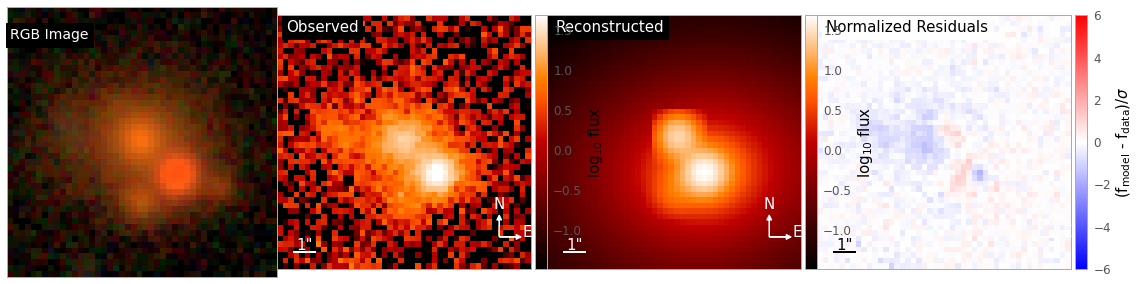

{'kwargs_lens': [{'theta_E': 1.4805928061566194, 'e1': 0.17902547925549392, 'e2': -0.22198301019413974, 'center_x': 1.38395412380516, 'center_y': -1.4534573950853706}, {'gamma1': -0.09298600777585476, 'gamma2': -0.07505686590472982, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 735.6749603704083, 'R_sersic': 1.5199502053034806, 'n_sersic': 3.4258920238230623, 'e1': 0.12814385319955274, 'e2': 0.02610743175549321, 'center_x': 1.4393917062199035, 'center_y': -1.4452202677333916}], 'kwargs_ps': [{'ra_image': array([0.19815561, 0.01553871, 2.49956705]), 'dec_image': array([ 0.28684541, -2.49696766, -1.84165827]), 'point_amp': array([7209.36995047, 1199.94266649, -397.25766811])}], 'kwargs_special': {}, 'kwargs_extinction': []}


In [42]:
## DES_4414
# coadd_id = 1087262176
background_rms = 7.
# image positions
x_images_4414 = [0.07,0.07,3.58]
y_images_4414 = [0.15,-2.63,-1.9]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': -0.05, 'e2': 0, 'center_x': 1.4 , 'center_y': -1.6}
kwargs_lens_light_initial= {'R_sersic': 2, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': 1.4 , 'center_y': -1.6}

# run model
model(coadd_id = 1087262176, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images_4414, y_images = y_images_4414, mask=None)

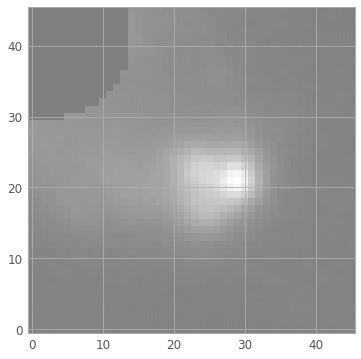

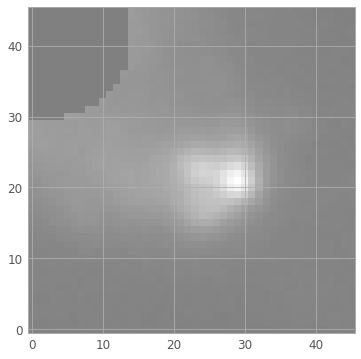

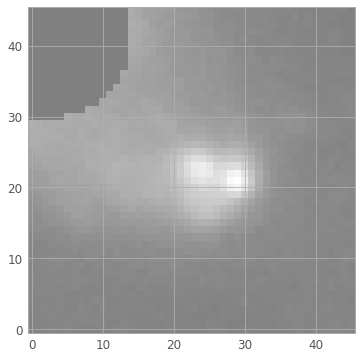

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.09526004574603225 reduced X^2 of best position
-301.212264648954 logL
6324.0 effective number of data points
[{'theta_E': 2.019872719390395, 'e1': 0.6951720376019204, 'e2': -0.4162880933613995, 'center_x': 1.5597841898632314, 'center_y': -0.656795739140523}, {'gamma1': 0.1759275628134121, 'gamma2': 0.18159459254873836, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 9.96067373455994, 'n_sersic': 3.2669448284186773, 'e1': 0.2739629421626836, 'e2': -0.045457683163210805, 'center_x': 0.488558064770755, 'center_y': -0.2525433075207935}] lens light result
[{'ra_image': array([0.2970355 , 2.49845603]), 'dec_image': array([-0.28495298,  1.30540225]), 'point_amp': array([1., 1.])}] point source result
{} special param result
52.06334733963013 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [01:13<00:00,  1.09it/s]


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  20
Sampling iterations (in current run): 80
74.59511590003967 time taken for MCMC sampling
-0.09492669913375856 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.05222658682255165
reduced chi^2 of data  1 =  0.1013022971877573
reduced chi^2 of data  2 =  0.13125121339096674


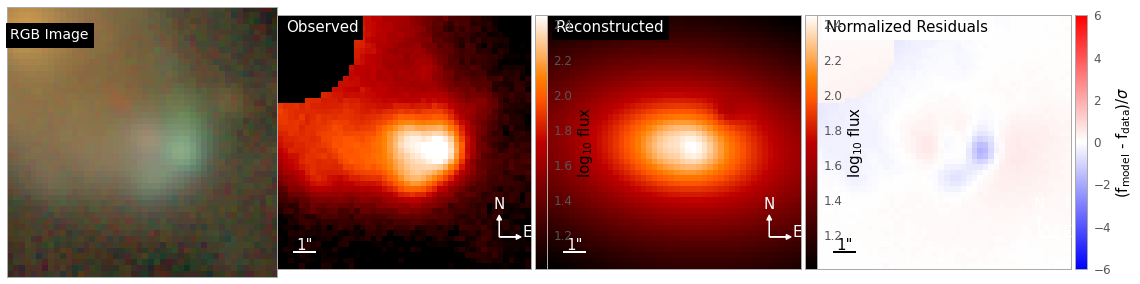

{'kwargs_lens': [{'theta_E': 2.048682471496397, 'e1': 0.69701645947789, 'e2': -0.46591824008162147, 'center_x': 1.5667082443102613, 'center_y': -0.6745755095685814}, {'gamma1': 0.1934406662087197, 'gamma2': 0.17229551052729658, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 168.8520554292201, 'R_sersic': 9.964190737328792, 'n_sersic': 3.3070657774711423, 'e1': 0.268478045827663, 'e2': -0.051267938594284045, 'center_x': 0.4771098954886165, 'center_y': -0.2507552632523332}], 'kwargs_ps': [{'ra_image': array([0.29574339, 2.49274895]), 'dec_image': array([-0.28767427,  1.30525669]), 'point_amp': array([-4449.2166154 ,  -511.63568415])}], 'kwargs_special': {}, 'kwargs_extinction': []}


In [45]:
## DES_0041
background_rms = 100

# coadd_id = 1325853948
# image positions
x_images_0041 = [0.11,3.61]
y_images_0041 = [-0.08,1.66]

# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0, 'e2': 0, 'center_x': 1.6 , 'center_y': -0.7}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 1.6 , 'center_y': -0.7}

# run model
model(coadd_id = 1325853948, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images_0041, y_images = y_images_0041,
      mask = {'mask_center_x': -5.3, 'mask_center_y': 4.9, 'mask_radius': 3}
     )



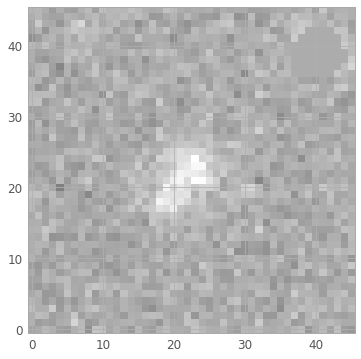

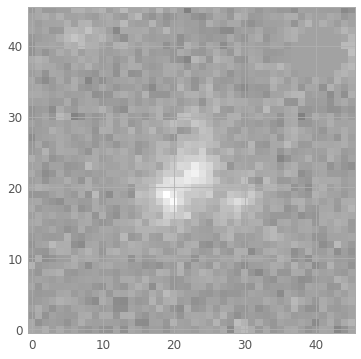

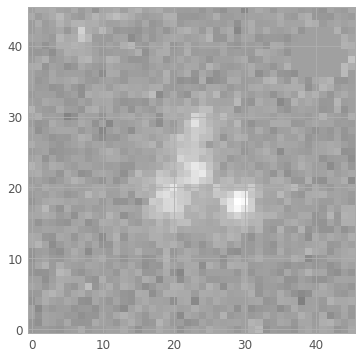

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.1783838979406495 reduced X^2 of best position
-563.4255416455414 logL
6317.0 effective number of data points
[{'theta_E': 1.5705041871071828, 'e1': 0.18644395496143235, 'e2': 0.1606162267209445, 'center_x': 0.026343393700436295, 'center_y': -0.5262268490643053}, {'gamma1': 0.01666492510528033, 'gamma2': -0.052882012691834214, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.339608968106368, 'n_sersic': 1.432009635188243, 'e1': -0.1736398618234855, 'e2': 0.18256235150289088, 'center_x': -0.01757764546933868, 'center_y': -0.13979001239940694}] lens light result
[{'ra_image': array([ 0.09616801, -0.88621446,  1.67197067]), 'dec_image': array([ 1.28884233, -1.04126058, -1.24407303]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
45.29711318016052 time used for  PSO


100%|███████████████████████████████████████████| 80/80 [01:11<00:00,  1.12it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  20
Sampling iterations (in current run): 80
72.44455695152283 time taken for MCMC sampling
-0.17718695380527802 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.06449166812477385
reduced chi^2 of data  1 =  0.09901686610640048
reduced chi^2 of data  2 =  0.3680523271846598


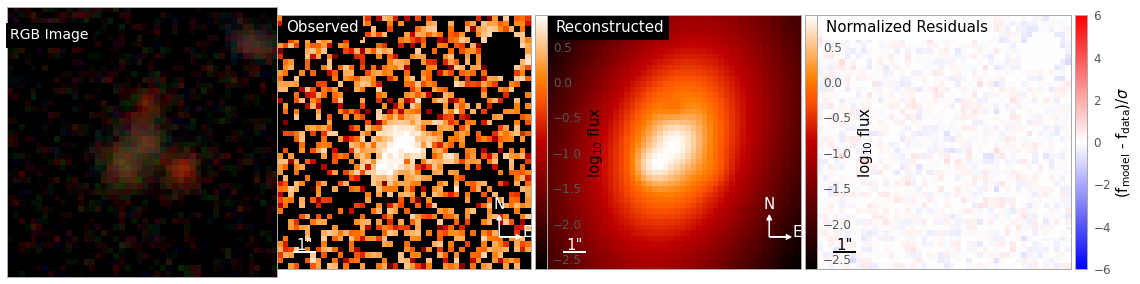

{'kwargs_lens': [{'theta_E': 1.5549594107306752, 'e1': 0.12516030864495992, 'e2': 0.13562732476597708, 'center_x': -0.016761347872895564, 'center_y': -0.5486408393899807}, {'gamma1': -0.018869795893852667, 'gamma2': -0.08128313033428347, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 79.51708705572311, 'R_sersic': 1.381213336795816, 'n_sersic': 1.5651311942709967, 'e1': -0.16694966206228615, 'e2': 0.13064209171394764, 'center_x': 0.020588443495208164, 'center_y': -0.12703978047834064}], 'kwargs_ps': [{'ra_image': array([ 0.09243258, -0.86713396,  1.67878255]), 'dec_image': array([ 1.2963999 , -1.05281901, -1.24225804]), 'point_amp': array([188.61727284, 309.70546128, 552.31459826])}], 'kwargs_special': {}, 'kwargs_extinction': []}


In [43]:
## DES_2915
# coadd_id = 1400263522
background_rms = 7.
# initial guesses for params
kwargs_lens_initial = {'theta_E': 1.5, 'e1': 0., 'e2': 0, 'center_x': 0. , 'center_y': -0.25}
kwargs_lens_light_initial= {'R_sersic': 1, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0. , 'center_y': -0.25}

# image positions
x_images_2915 = [-0.07,-0.96,1.61]
y_images_2915 = [1.33,-1.17,-1.38]

# run model
model(coadd_id = 1400263522, 
      kwargs_lens_initial = kwargs_lens_initial, 
      kwargs_lens_light_initial = kwargs_lens_light_initial,
      x_images = x_images_2915, y_images = y_images_2915,
      mask = {'mask_center_x': 4.7, 'mask_center_y': 4.3, 'mask_radius': 1}
     )